In [1]:
import json
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

from simulator import generate_daily_data, Simulator

# Sample run

In [2]:
graph_dict = json.load(open("graph_dict.json"))

In [3]:
sim = Simulator(graph_dict=graph_dict)
sim.run()

/tmp/ipykernel_28131/424760659.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_28131/424760659.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./plots/compartments.pdf",dpi=300)
/tmp/ipykernel_28131/424760659.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./plots/compartments.pdf",dpi=300)
/home/zsvizi/workspace/propensity-matrix-epidemics/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


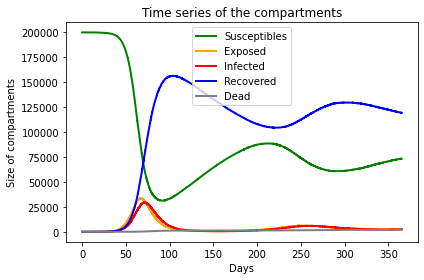

In [4]:
# Code to show graph

aggregated = np.sum(sim.state_var, axis=2)

fig, ax = plt.subplots()
ax.plot(sim.time_series, aggregated[:, sim.c_idx["S"]], "g", label="Susceptibles", linewidth=2)
ax.plot(sim.time_series, aggregated[:, sim.c_idx["E"]], "orange", label="Exposed", linewidth=2)
ax.plot(sim.time_series, aggregated[:, sim.c_idx["I"]], "r", label="Infected", linewidth=2)
ax.plot(sim.time_series, aggregated[:, sim.c_idx["R"]], "b", label="Recovered", linewidth=2)
ax.plot(sim.time_series, aggregated[:, sim.c_idx["D"]], "gray", label="Dead", linewidth=2)
ax.legend()
plt.xlabel("Days")
plt.ylabel("Size of compartments")
plt.title("Time series of the compartments")
plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig("./plots/compartments.pdf",dpi=300)
plt.show()

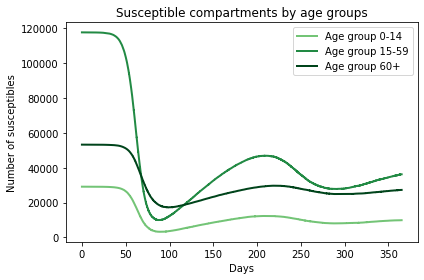

In [5]:
# Code to show graph
colors = cm.Greens(0.5+np.linspace(0, 0.5, 3))

fig, ax = plt.subplots()
ax.plot(sim.time_series, sim.state_var[:, sim.c_idx["S"], 0],
        color=colors[0], label="Age group 0-14", linewidth=2)
ax.plot(sim.time_series, sim.state_var[:, sim.c_idx["S"], 1],
        color=colors[1], label="Age group 15-59", linewidth=2)
ax.plot(sim.time_series, sim.state_var[:, sim.c_idx["S"], 2],
        color=colors[2], label="Age group 60+", linewidth=2)
ax.legend()
plt.xlabel("Days")
plt.ylabel("Number of susceptibles")
plt.title("Susceptible compartments by age groups")
plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig("./plots/susceptible_age_groups.pdf",dpi=300)
plt.show()

# Multiple runs from a given point

In [6]:
sim_original = Simulator(graph_dict=graph_dict)
sim_original.run_after_csocs(days=10)

In [7]:
time = np.array(sim_original.time_series).searchsorted(35)
time1 = np.array(sim_original.time_series).searchsorted(25)

In [8]:
ts_list = []
i_list = []
for i in range(3):
    sim_1 = Simulator(graph_dict=graph_dict)
    sim_1.reset_for_new_simulation(init=sim_original.state_var[time])
    sim_1.run_after_csocs(10)
    
    aggregated = np.sum(sim_1.state_var, axis=2)
    
    ts_list.append(sim_1.time_series[:])
    i_list.append(aggregated[:, sim_1.c_idx["I"]])

In [9]:
aggregated = np.sum(sim_original.state_var, axis=2)
i_time_series = sim_original.time_series[time1:time]
i_values = aggregated[time1:time, sim_original.c_idx["I"]]
days = [26]
day_i = [i_values[0]]
for t in range(1,len(i_time_series)):
    actual_time = i_time_series[t]
    prev_time = i_time_series[t-1]
    if prev_time <= days[-1] < actual_time:
        days.append(days[-1]+1)
        day_i.append(i_values[t-1])

# days, day_i = generate_daily_data(time_series=i_time_series, values=i_values)

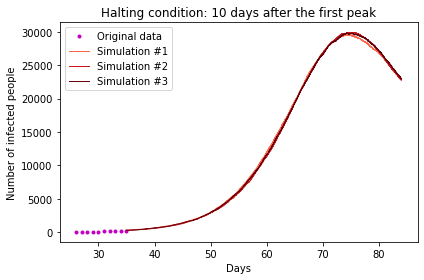

In [10]:
fig, ax = plt.subplots()
aggregated = np.sum(sim_original.state_var, axis=2)
ax.plot(days, day_i, "m.", linewidth=2, label="Original data")

color = cm.Reds(0.5+np.linspace(0, 0.5, len(ts_list)))
for i, c in zip(range(len(ts_list)), color):
    ax.plot(sim_original.time_series[time]+np.array(ts_list[i]), i_list[i],
            color=c, linewidth=1, label="Simulation #"+str(i+1))
plt.xlabel("Days")
plt.ylabel("Number of infected people")
plt.title("Halting condition: 10 days after the first peak")
plt.legend()
plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig("./plots/stop_after_peak.pdf",dpi=300)
plt.show()

# Contact reduction

In [11]:
sim_original = Simulator(graph_dict=graph_dict)
sim_original.run_after_csocs(20)

In [12]:
time1 = np.array(sim_original.time_series).searchsorted(30)
time2 = np.array(sim_original.time_series).searchsorted(45)

In [13]:
ts_list = []
i_list = []
for i in range(1,4):
    sim_1 = Simulator(graph_dict=graph_dict)
    sim_1.reset_for_new_simulation(init=sim_original.state_var[time2])
    sim_1.model.contact_matrix = sim_1.model.contact_matrix * (1 - 0.1 * i)
    sim_1.run_after_csocs(10)
    
    aggregated = np.sum(sim_1.state_var, axis=2)
    
    ts_list.append(sim_1.time_series[:])
    i_list.append(aggregated[:, sim_1.c_idx["I"]])

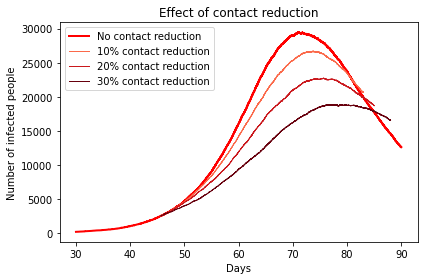

In [14]:
fig, ax = plt.subplots()
aggregated = np.sum(sim_original.state_var, axis=2)
i_lista = aggregated[:, sim_original.c_idx["I"]]
ax.plot(sim_original.time_series[time1:], i_lista[time1:], "r",
        linewidth=2, label="No contact reduction")

color = cm.Reds(0.5+np.linspace(0, 0.5, len(ts_list)))
for i, c in zip(range(len(ts_list)), color):
    ax.plot(sim_original.time_series[time2]+np.array(ts_list[i])[time1:], i_list[i][time1:], color=c,
            linewidth=1, label=str((i+1)*10) + "% contact reduction")
plt.xlabel("Days")
plt.ylabel("Number of infected people")
plt.title("Effect of contact reduction")
plt.legend()
plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig("./plots/contact_reduction.pdf",dpi=300)
plt.show()

# Simulation with confidence calculation

In [15]:
do_conf_simulation = False

In [16]:
graph_dict = json.load(open("graph_dict.json"))
sim = Simulator(graph_dict=graph_dict)

In [17]:
if do_conf_simulation:
    sim.run_conf()

In [18]:
# Number of simulations
n_simulations = 104
# List for storing infection curves for all simulations
to_plot = []
# List for storing peak sizes from all simulations
peak_sizes = []
# List for storing daily sampled data
daily_data = []

for sim_cnt in range(n_simulations):
    # Load data
    data=np.load("./data/simulation_" + str(sim_cnt) + ".npz")
    time_series = data['t']
    state_var = data['y']
    aggregated = np.sum(state_var, axis=2)
    
    # Save data for multiple time series plot
    to_plot.append((time_series, aggregated[:, sim.c_idx["I"]]))

    # Generate daily data
    days, day_i = generate_daily_data(time_series=time_series, values=aggregated[:, sim.c_idx["I"]])
    daily_data.append((days, day_i))

    # Save data for confidence calculation
    i_agg_max = np.amax(aggregated[:, sim.c_idx["I"]])
    peak_sizes.append(i_agg_max)

# Standard deviation calculated for confidence band
s = np.std(np.array(peak_sizes))

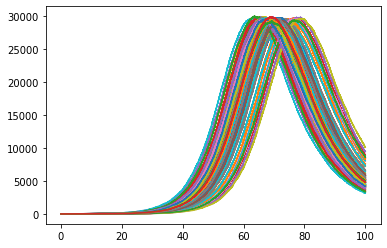

In [19]:
# Plot multiple loaded time series

fig, ax = plt.subplots()
for ts, sv in to_plot:
    ax.plot(ts, sv)
plt.show()

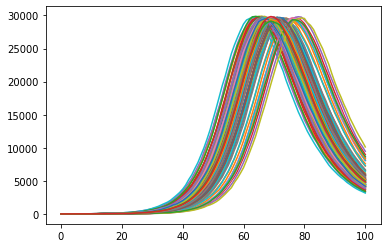

In [20]:
# Plot multiple daily time series

fig, ax = plt.subplots()
for ts, sv in daily_data:
    ax.plot(ts, sv)
plt.show()

In [21]:
os.makedirs('./plots', exist_ok=True)
fig.savefig('./plots/conf_plot.pdf')

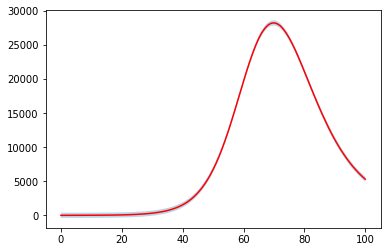

In [22]:
# Plot confidence band

y_data = np.array([v for t, v in daily_data])

fig, ax = plt.subplots()
y_mean = np.mean(y_data, axis=0)
ax.fill_between(daily_data[0][0], y_mean - 2 * s, y_mean + 2 * s, alpha=0.3)
ax.plot(daily_data[0][0], y_mean, "r")
plt.show()

In [23]:
os.makedirs('./plots', exist_ok=True)
fig.savefig('./plots/conf_plot_2.pdf')

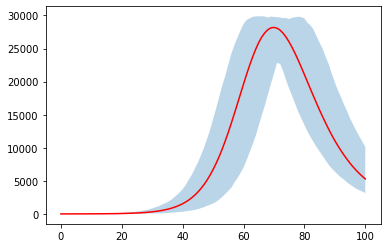

In [24]:
# Plot confidence band

y_data = np.array([v for t, v in daily_data])

fig, ax = plt.subplots()
y_mean = np.mean(y_data, axis=0)
y_min = np.amin(y_data, axis=0)
y_max = np.amax(y_data, axis=0)
ax.fill_between(daily_data[0][0], y_min, y_max, alpha=0.3)
ax.plot(daily_data[0][0], y_mean, "r")
plt.show()

In [25]:
os.makedirs('./plots', exist_ok=True)
fig.savefig('./plots/conf_plot_3.pdf')

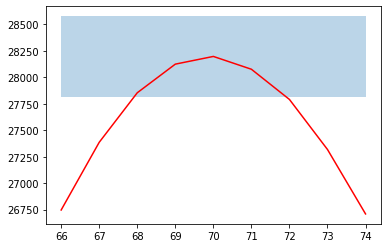

In [26]:
# Plot confidence band

y_data = np.array([v for t, v in daily_data])

fig, ax = plt.subplots()
y_mean = np.mean(y_data, axis=0)
peak = np.amax(y_mean) * np.ones_like(y_mean)
t_vec = np.array(daily_data[0][0])
filt = (65 < t_vec) & (t_vec < 75)

ax.fill_between(t_vec[filt], peak[filt] - 2 * s, peak[filt] + 2 * s, alpha=0.3)
ax.plot(t_vec[filt], y_mean[filt], "r")
plt.show()

In [27]:
os.makedirs('./plots', exist_ok=True)
fig.savefig('./plots/conf_plot_4.pdf')

In [28]:
print(np.array([len(v) for _, v in daily_data]))
print(np.array([len(t) for t, _ in daily_data]))

[101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101]
[101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
 101 101 101 101 101 101 101 101 101 101 101 101 101 101]
